In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss

In [11]:
sns.set(rc={'figure.figsize':(16,8)}, style = "whitegrid")

In [5]:
bicycles = pd.read_csv('https://stepik.org/media/attachments/lesson/384464/london.csv', parse_dates = ['timestamp'])
bicycles.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.

Есть ли в данных пропущенные значения?

In [6]:
bicycles.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

Для начала попробуем посмотреть на число поездок по датам и времени. Постройте график, где:

по оси x – дата (timestamp)
по оси y – число поездок (cnt)
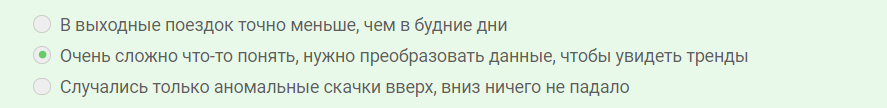

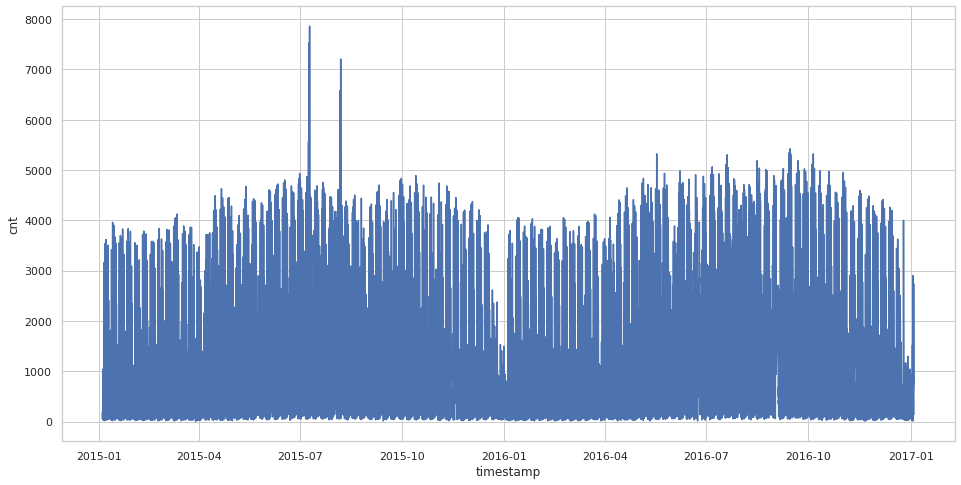

In [12]:
sns.lineplot(x = bicycles.timestamp, y = bicycles.cnt);

Отлично! Предположим, что данные действительно нужно немного преобразовать. В этом нам поможет resample, с которым вы могли столкнуться в дополнительных темах pandas. Этот метод позволяет преобразовать данные и применить к какому-либо столбцу другой метод (напр. sum). Так можно рассчитать показатели, например, за весь день или месяц, имея данные с точностью до минут. Например, посчитать сумму показателя по дням, имея данные по часам, можно следующим образом:

data.resample(rule='D').column_name.sum()
data.resample(rule='D').agg({'column_name':'sum'})
Агрегируйте число поездок по дням и визуализируйте результат. Что вы можете сказать о полученном графике?

In [15]:
bicycles.sort_values(by='timestamp', inplace = True)
bicycles.set_index('timestamp', drop = False, inplace = True)

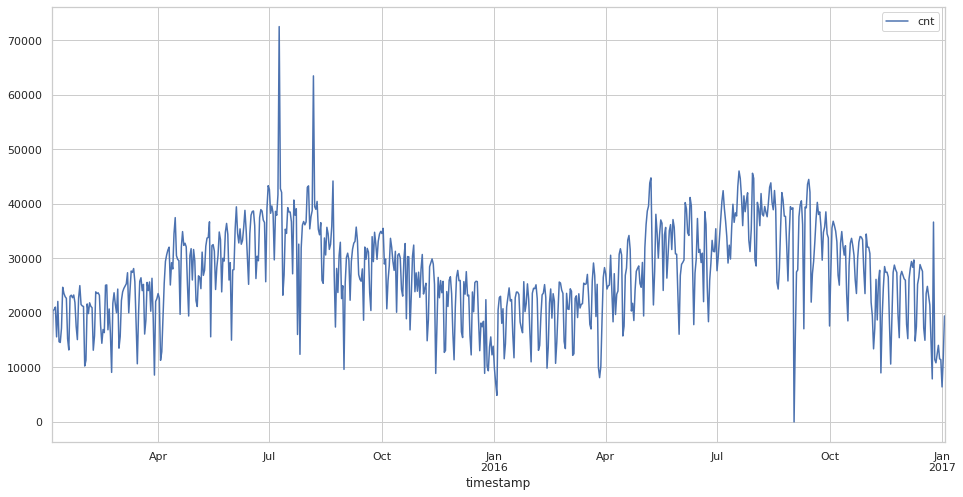

In [20]:
bicycles.resample(rule='D').agg({'cnt':'sum'}).plot();

Итак, вы обнаружили на графике некоторые скачки. Давайте проверим, что же могло произойти в тот день 🤔.

Для этого разделим дальнейшие действия на несколько этапов:

сначала посчитаем скользящее среднее, чтобы сгладить ряд
далее – разницу между наблюдаемыми и сглаженными значениями
определим верхние и нижние границы 99% доверительного интервала 
найдем причины аномалий!
На данном шаге возьмите агрегированные данные по дням с предыдущего шага и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.

In [26]:
bicycles_by_day = bicycles.resample(rule='D').agg({'cnt':'sum'}).reset_index()

In [28]:
bicycles_by_day_rolling = bicycles.resample(rule='D').agg({'cnt':'sum'}).rolling(window=3).mean().reset_index()
bicycles_by_day_rolling.head()

,timestamp,cnt
0,2015-01-04,NaN
1,2015-01-05,NaN
2,2015-01-06,16739.666667
3,2015-01-07,20683.000000
4,2015-01-08,19092.666667


In [29]:
round(bicycles_by_day_rolling.query('timestamp == "2015-07-09"'))

,timestamp,cnt
186,2015-07-09,50705.0


Теперь посчитайте разницу между наблюдаемыми и подсчитанными значениями. Далее – примените функцию для подсчета стандартного отклонения. Например:

c = a - b
std = np.std(c)
В качестве ответа введите полученное стандартное отклонение, округленное до 2 знаков после точки.

In [31]:
difference = bicycles.resample(rule='D').agg({'cnt':'sum'}).reset_index()['cnt'] - bicycles.resample(rule='D').agg({'cnt':'sum'}).rolling(window=3).mean().reset_index()['cnt']

In [33]:
std = round(np.std(difference),2)
std

4558.59

Теперь определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:

upper_bound – верхняя граница; к средним прибавляем 2.576 * std
lower_bound – нижняя граница; вычитаем 2.576 * std
Полученные значения запишите в новые столбцы датафрейма с агрегированными данными.

Чему равно значение верхней границы для последнего наблюдения? Ответ укажите с точностью до 2 знаков после точки.

Note: в качестве std нужно брать стандартное отклонение без округления.

In [34]:
upper_bound = bicycles_by_day_rolling.cnt + (2.576 * std)
lower_bound = bicycles_by_day_rolling.cnt - (2.576 * std)

In [36]:
round(upper_bound.loc[730],2)

24302.93

In [37]:
bicycles_by_day['upper_bound'] = upper_bound
bicycles_by_day['lower_bound'] = lower_bound
bicycles_by_day

,timestamp,cnt,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,28482.594507,4996.738827
3,2015-01-07,21064,32425.927840,8940.072160
4,2015-01-08,15601,30835.594507,7349.738827
...,...,...,...,...
726,2016-12-30,11566,24424.927840,939.072160
727,2016-12-31,11424,24090.261173,604.405493
728,2017-01-01,6421,21546.594507,-1939.261173
729,2017-01-02,11823,21632.261173,-1853.594507


И наконец – изучим аномально высокие значения! Сначала выведите наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

В какой день значение числа аренд оказалось наибольшим? Укажите дату в формате 2020-12-31.

In [39]:
bicycles_by_day[bicycles_by_day.cnt > bicycles_by_day.upper_bound].sort_values(by='cnt')

,timestamp,cnt,upper_bound,lower_bound
609,2016-09-04,27512,26001.927840,2516.072160
721,2016-12-25,36653,31393.594507,7907.738827
214,2015-08-06,63468,58370.261173,34884.405493
186,2015-07-09,72504,62447.927840,38962.072160


Проделайте аналогичную операцию для дней, когда число аренд оказалось ниже ожидаемого. В чем может быть причина падения числа аренд 2016-09-02?

In [40]:
bicycles_by_day[bicycles_by_day.cnt < bicycles_by_day.lower_bound]

,timestamp,cnt,upper_bound,lower_bound
130,2015-05-14,15609,40452.261173,16966.405493
189,2015-07-12,23240,47779.594507,24293.738827
201,2015-07-24,16034,42756.594507,19270.738827
232,2015-08-24,17400,41272.261173,17786.405493
314,2015-11-14,8898,32780.261173,9294.405493
607,2016-09-02,0,37829.261173,14343.405493
615,2016-09-10,17080,43004.927840,19519.072160
621,2016-09-16,21967,47936.261173,24450.405493
678,2016-11-12,8990,32620.927840,9135.072160
